In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

from ionpy.analysis import ResultsLoader
from ese.experiment.experiment import CalibrationExperiment
import seaborn as sns
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))
os.environ["CUDA_VISIBLE_DEVICES"] = '3' 

%load_ext yamlmagic
%load_ext autoreload
%autoreload 2

/storage/vbutoi/libraries/pylot/pandas/register.py:47: UserWarning: registration of accessor <class 'pylot.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'fillNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/libraries/pylot/pandas/register.py:47: UserWarning: registration of accessor <class 'pylot.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'isNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/libraries/pylot/pandas/register.py:47: UserWarning: registration of accessor <class 'pylot.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'notNA' for type <class 'pandas.core.series.Series'> is overridi

In [2]:
# Results loader object does everything
rs = ResultsLoader()
root = "/storage/vbutoi/scratch/ESE"

In [3]:
path = f"{root}/WMH_aug_runs"

dfc = rs.load_configs(
    path,
    properties=False,
)

df = rs.load_metrics(dfc)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
best_exp = rs.get_experiment(
    df=df,
    exp_class=CalibrationExperiment,
    metric="val-dice_score",
    checkpoint="max-val-dice_score",
    device="cuda"
)

/storage/vbutoi/projects/ionpy/util/libcheck.py:57: UserWarning: Using slow Pillow instead of Pillow-SIMD
  warn("Using slow Pillow instead of Pillow-SIMD")


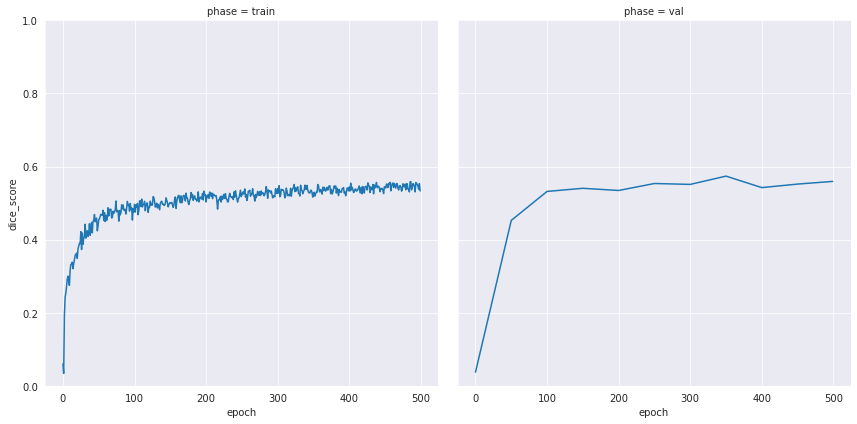

In [5]:
best_exp.vis_loss_curves(height=6)

In [6]:
%%yaml dataset_cfg 

_class: ese.experiment.datasets.WMH
annotator: observer_o12
axis: 0
split: val 
num_slices: 1
slicing: midslice 
task: Amsterdam 
version: 0.2

<IPython.core.display.Javascript object>

In [7]:
from ionpy.experiment.util import absolute_import
from torch.utils.data import DataLoader

dataset_cls = absolute_import(dataset_cfg.pop("_class"))
WMH_Dataset = dataset_cls(**dataset_cfg)
wmh_dataloader = DataLoader(WMH_Dataset, batch_size=1, shuffle=False, drop_last=False)

In [8]:
from ionpy.util.torchutils import to_device
import torch
import numpy as np
from tqdm.notebook import tqdm
from ionpy.metrics import dice_score
import einops

def get_dataset_perf(
        exp, 
        dataloader, 
        slice_batch_size=1,
        background_threshold=0.0001
        ):

    items = []
    with torch.no_grad():
        for _, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
            
            # Get your image label pair and define some regions.
            x, y = to_device(batch, exp.device)
            
            # Reshape to a good size
            x = einops.rearrange(x, "b c h w -> (b c) 1 h w")
            y = einops.rearrange(y, "b c h w -> (b c) 1 h w")
                             
            yhat = exp.model(x)  
            fore_regions = (y==1)
            back_regions = (y==0)
            
            # Extract predictions
            soft_foreground_pred = torch.sigmoid(yhat)
            # If you want to eliminate background pixels, do so
            if background_threshold > 0:
                soft_foreground_pred[soft_foreground_pred < background_threshold] = 0

            soft_background_pred = 1 - soft_foreground_pred 

            hard_foreground_pred = (soft_foreground_pred > 0.5).float()
            hard_background_pred = 1 - hard_foreground_pred

            # Compute metrics
            dice_met = np.round(dice_score(yhat, y).cpu().numpy(), 3)
            loss_image = (y - soft_foreground_pred) # Not really all that meaningful, just looking at per-pixel differences (can be thought of as soft accuracy).

            ## Calculate calibration image.

            # The calibration image is define as PER-PIXEL the difference between (accu(P) - conf(P)).
            calibration_image = torch.zeros_like(loss_image)
            foreground_accuracy = (y == hard_foreground_pred).float()
            background_accuracy = ((1 - y) == hard_background_pred).float()

            # Set the regions of the image corresponding to groundtruth label.
            calibration_image[fore_regions] = (foreground_accuracy - soft_foreground_pred).abs()[fore_regions]
            calibration_image[back_regions] = (background_accuracy - soft_background_pred).abs()[back_regions]
            
            ## Finally, we want to calculate two tensors (one for each class) that consists of two channels:
            # 1. The match of the prediction
            # 2. The confidence of the prediction
            pix_info = {
                "foreground": torch.stack([foreground_accuracy, soft_foreground_pred], dim=0).view(2, -1).cpu().numpy(),
                "background": torch.stack([background_accuracy, soft_background_pred], dim=0).view(2, -1).cpu().numpy()
            }

            # Wrap it in an item
            items.append({
                "image": x.cpu().squeeze(),
                "label": y.cpu().squeeze(),
                "soft_pred": soft_foreground_pred.cpu().squeeze(),
                "hard_pred": hard_foreground_pred.cpu().numpy().squeeze(),
                "dice_score": dice_met,
                "loss": loss_image.cpu().numpy().squeeze(),
                "calibration err": calibration_image.cpu().numpy().squeeze(),
                "pix_info": pix_info
            })

    return items

In [9]:
# val_perf is a dict where each item is the subj id
# with the y, ypred, yloss, ydice
predictions_dict = get_dataset_perf(
    exp=best_exp, 
    dataloader=wmh_dataloader
    )

  0%|          | 0/15 [00:00<?, ?it/s]

In [10]:
import matplotlib.pyplot as plt

def visualize_predictions(perf_dict):
    # We are going to visualize 5 things here
    # - The image
    # - The ground truth
    # - The hard prediction (with loss above it)
    # - The delta between the ground truth and the soft prediction
    # - The Calibration error (Acc - Soft Pred)

    color_dict = {
        "loss": "twilight",
        "calibration err": "plasma",
    }

    skip_keys = ["pix_info"]

    for subj in perf_dict:

        # Create the subplots for this subject
        num_keys = len(subj.keys()) - len(skip_keys)
        f, axarr = plt.subplots(1, num_keys, figsize=(5 * num_keys, 5))

        for k_idx, key in enumerate(subj.keys()):
            if key not in skip_keys:
                if key in color_dict:
                    im = axarr[k_idx].imshow(subj[key], cmap=color_dict[key])
                else:
                    im = axarr[k_idx].imshow(subj[key], cmap="gray")
                axarr[k_idx].axis("off")
                axarr[k_idx].set_title(key)
                f.colorbar(im, ax=axarr[k_idx])

        plt.show()

In [11]:
from ese.experiment.metrics import ECE
from ese.experiment.analysis.plots import plot_reliability_diagram

def plot_calibration_plot(
    pred_dict, 
    num_bins,
    style='bar'
    ):

    # Get the prediction info.
    pixel_info = [subj["pix_info"] for subj in pred_dict]

    # Establish color scheme.
    label_dict = {
        "foreground": "blue",
        "background": "green"
    }

    # Build the figure
    _, ax = plt.subplots(2, len(num_bins), figsize=(len(num_bins)*6, 12))
    axis_lower_bound = 1 / len(label_dict.keys())

    # Loop through our labels
    for l_idx, label in enumerate(label_dict.keys()):

        accuracies = np.concatenate([pi[label][0] for pi in pixel_info])
        confidences = np.concatenate([pi[label][1] for pi in pixel_info])

        # One issue is that we want to look maybe with different bin sizes, so 
        # lets look at a range.
        for g_idx in range(len(num_bins)):
            
            # Calulate the bins and spacing
            interval_size = 1 / num_bins[g_idx]
            all_bins = np.linspace(0, 1, num_bins[g_idx] + 1)[:-1] # Off by one error, chop off the highest number.

            bins = all_bins[all_bins >= axis_lower_bound]
            print(bins)

            # For each bin, calculate the mean accuracy within the bin  
            bar_heights = [np.mean(accuracies[(confidences >= b) & (confidences < (b + interval_size))]) for b in bins]

            if len(num_bins) == 1:
                target_ax = ax[l_idx]
            else:
                target_ax = ax[l_idx, g_idx]

            plot_reliability_diagram(
                bins,
                bar_heights,
                ax=target_ax,
                title=f"{label}, {num_bins[g_idx]} Bins, ECE: {ECE(accuracies, confidences, bins=bins, lower_bound=0.5)}",
                x_label="Confidence",
                y_label=f"Average accuracy",
                bin_color=label_dict[label]
            )

    plt.show()

# 1. What if we mix all calibration errors from all of the pixels of all of the images? Here is that histogram.

[0.5 0.6 0.7 0.8 0.9]
[0.5 0.6 0.7 0.8 0.9]


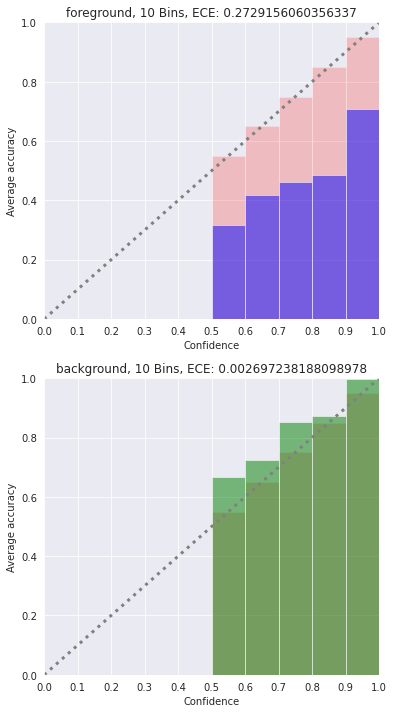

In [12]:
plot_calibration_plot(
    pred_dict=predictions_dict,
    num_bins=[10],
    style='bar'
    )

# 2. Let's look at how the ECE looks like if we evaluate over subjects, and what the distribution looks like.

In [13]:
ece_foreground_scores = [ECE(subj["pix_info"]["foreground"][0], subj["pix_info"]["foreground"][1], bin_range=[0.5, 1], bins=40) for subj in predictions_dict]

In [14]:
np.mean(ece_foreground_scores)

0.3046705377638619

<Axes: ylabel='Count'>

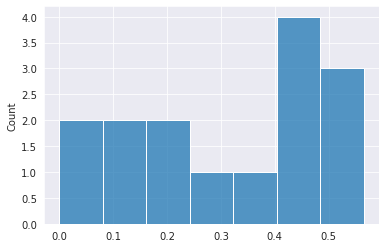

In [15]:
sns.histplot(ece_foreground_scores, bins=7)

# 3. Expected Semantic Error (ESE) 

In [27]:
import ionpy
from ese.experiment.metrics import ESE


def subject_plot(
    plot_type,
    subject_dict, 
    num_bins,
    metric="accuracy",
    aggregate=False,
    num_rows=3,
    show_subj=False):

    metric_dict = {
        "dice": ionpy.metrics.dice_score,
        "accuracy": ionpy.metrics.pixel_accuracy
    }

    # Calculate the bins and spacing
    bins = np.linspace(0, 1, num_bins+1)[:-1] # Off by one error

    # If we aggregate that means we combine all the subjects
    # per bin via their average
    if aggregate:
        _, axarr = plt.subplots(1, 1, figsize=(15, 10))
        ese_info = [ESE(subj["soft_pred"], subj["label"], metric_dict[metric], num_bins) for subj in subject_dict]
        ese_per_bin = np.mean([ese[0] for ese in ese_info], axis=0)
        bin_amounts = np.sum([ese[1] for ese in ese_info], axis=0)
        bin_proportions = bin_amounts / np.sum(bin_amounts)

        if plot_type == "ese_plot":
            plot_reliability_diagram(
                bins,
                ese_per_bin,
                ax=axarr,
                title=f"Total ESE: {np.average(ese_per_bin, weights=bin_proportions):.5f}",
                x_label="Confidence",
                y_label=f"Average {metric}",
                bin_color="blue"
            )
        else:
            axarr.hist(
                bins,
                bin_proportions,
                ax=axarr,
                title=f"Pred Confidence Histogram",
                x_label="Confidence",
                y_label=f"Amount",
                bin_color="green"
            )

    # Else we plot the reliability diagram for each subject
    else:
        # if you want to see the subjects and predictions
        if show_subj:
            _, axarr = plt.subplots(nrows=len(subject_dict), ncols=4, figsize=(24, len(subject_dict)*6))
        # Otherwise clump the graphs together
        else:
            _, axarr = plt.subplots(nrows=num_rows, ncols=len(subject_dict) // num_rows, figsize=(len(subject_dict) * 6, num_rows*15))
            
        for subj_idx, subj in enumerate(subject_dict):

            # This returns a numpy array with the measure per confidence interval
            ese_per_bin, bin_amounts = ESE(subj["soft_pred"], subj["label"], metric_dict[metric], bins)
            bin_proportions = bin_amounts / np.sum(bin_amounts)

            if show_subj:
                axarr[subj_idx, 0].imshow(subj["image"], cmap="gray")
                axarr[subj_idx, 0].axis("off")
                axarr[subj_idx, 0].set_title("Image")

                axarr[subj_idx, 1].imshow(subj["label"], cmap="gray")
                axarr[subj_idx, 1].axis("off")
                axarr[subj_idx, 1].set_title("Ground Truth")

                axarr[subj_idx, 2].imshow(subj["soft_pred"], cmap="gray")
                axarr[subj_idx, 2].axis("off")
                axarr[subj_idx, 2].set_title(f"Prediction, Dice: {subj['dice_score']:.3f}")

                subj_row = subj_idx
                subj_col = 3
            else:  
                num_per_row = len(subject_dict) // num_rows
                subj_row = subj_idx // num_per_row
                subj_col = subj_idx % num_per_row

            if plot_type == "ese_plot":
                plot_reliability_diagram(
                    bins,
                    ese_per_bin,
                    ax=axarr[subj_row, subj_col],
                    title=f"Subject #{subj_idx}, ESE: {np.average(ese_per_bin, weights=bin_proportions):.5f}",
                    x_label="Confidence",
                    y_label=f"Average {metric}",
                    bin_color="blue"
                )
            else:
                axarr[subj_row, subj_col].hist(
                    subj["soft_pred"].flatten(),
                    bins=bins,
                    color="green"
                )
                axarr[subj_row, subj_col].set_title(f"Subject #{subj_idx}, Confidence Histogram")
                axarr[subj_row, subj_col].set_xlabel("Confidence")
                axarr[subj_row, subj_col].set_ylabel("Amount")
    plt.show()

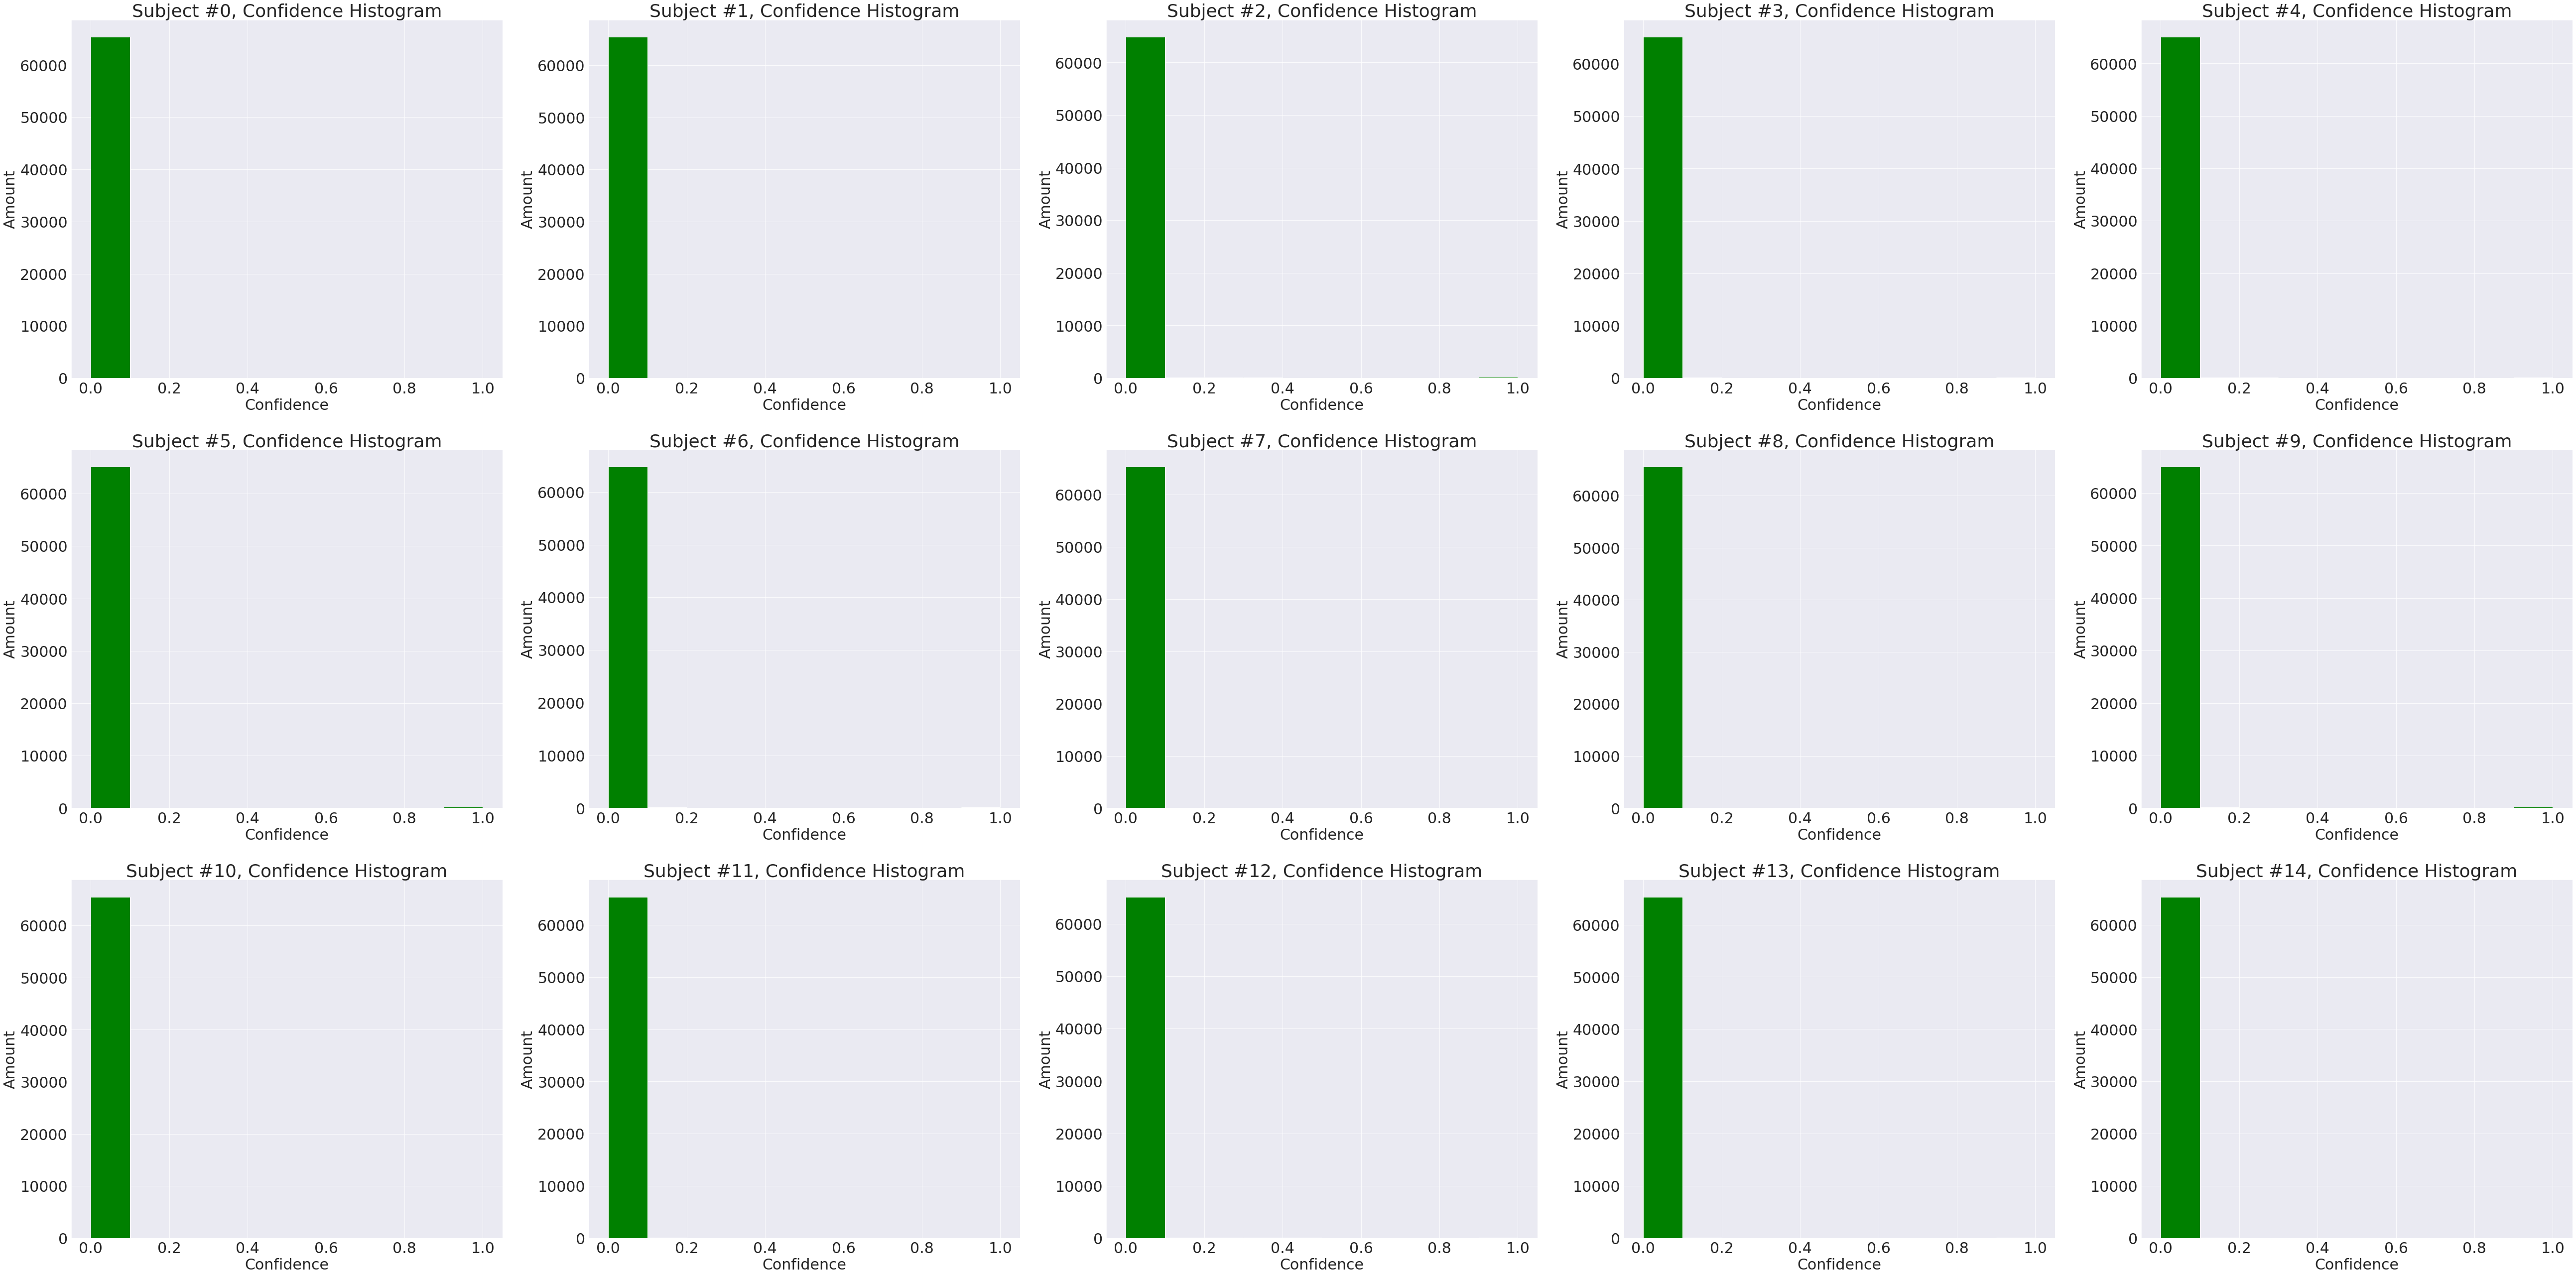

In [23]:
plt.rcParams.update({'font.size': 30})  # Change the value to the desired font size

subject_plot(
    plot_type='conf_hist',
    subject_dict=predictions_dict,
    num_bins=10,
    aggregate=False,
    num_rows=3,
    show_subj=False
)

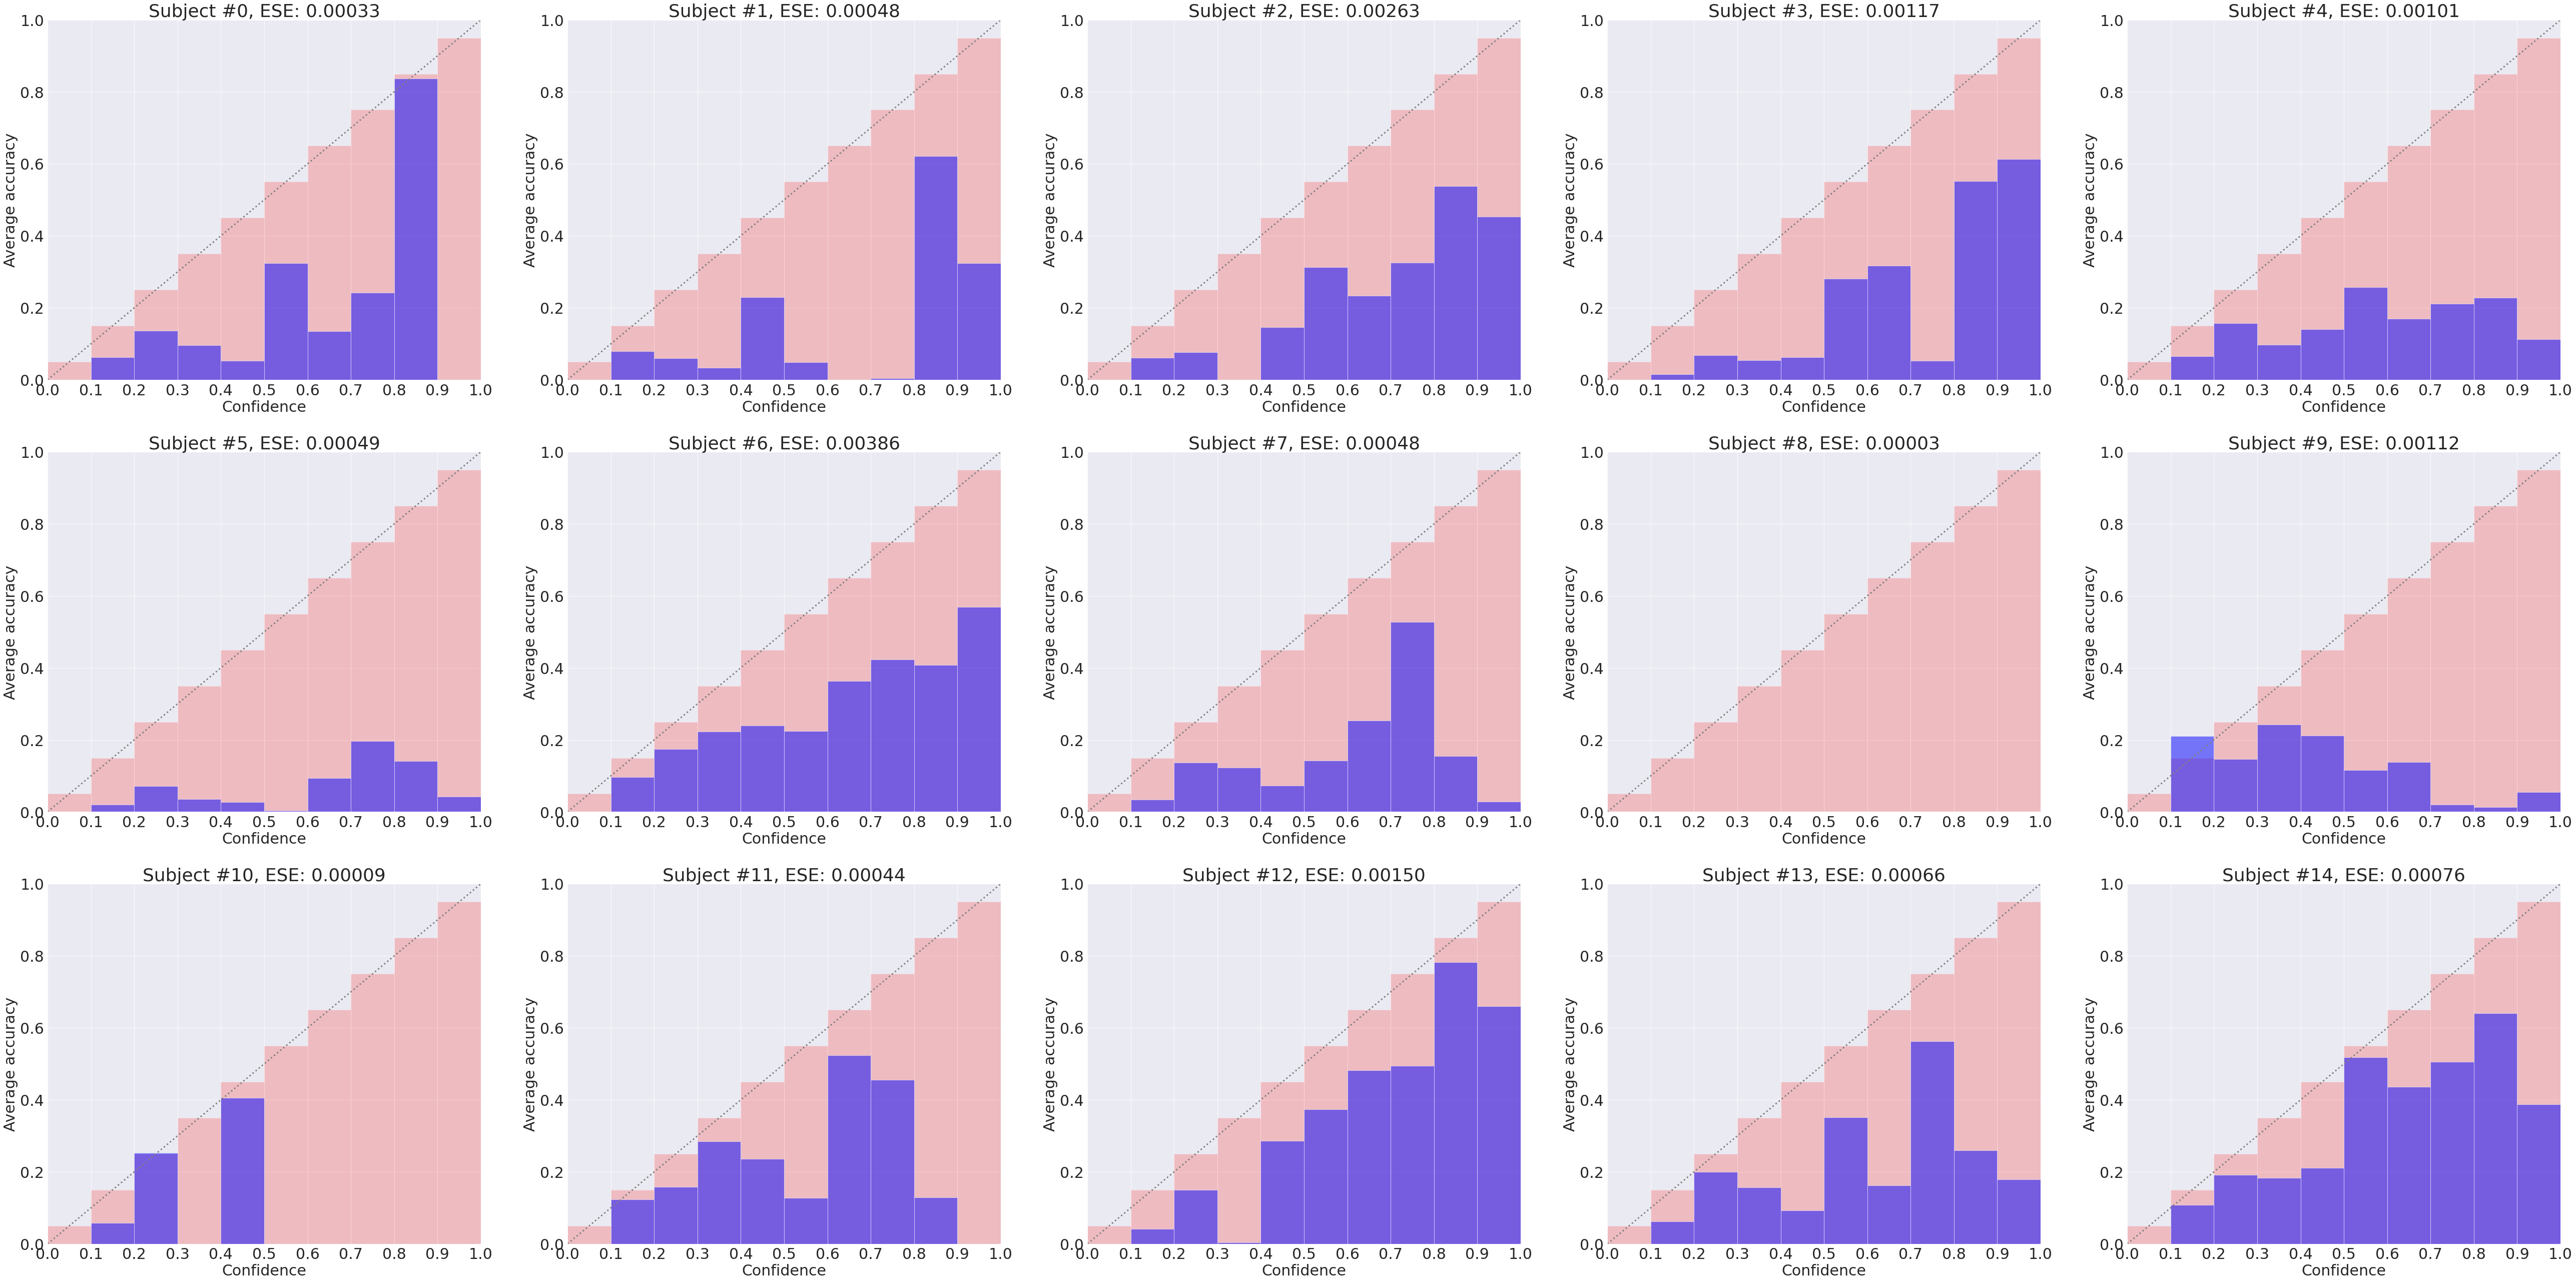

In [28]:
plt.rcParams.update({'font.size': 30})  # Change the value to the desired font size

subject_plot(
    plot_type='ese_plot',
    subject_dict=predictions_dict,
    num_bins=10,
    aggregate=False,
    num_rows=3,
    show_subj=False
)

TypeError: 'int' object is not subscriptable

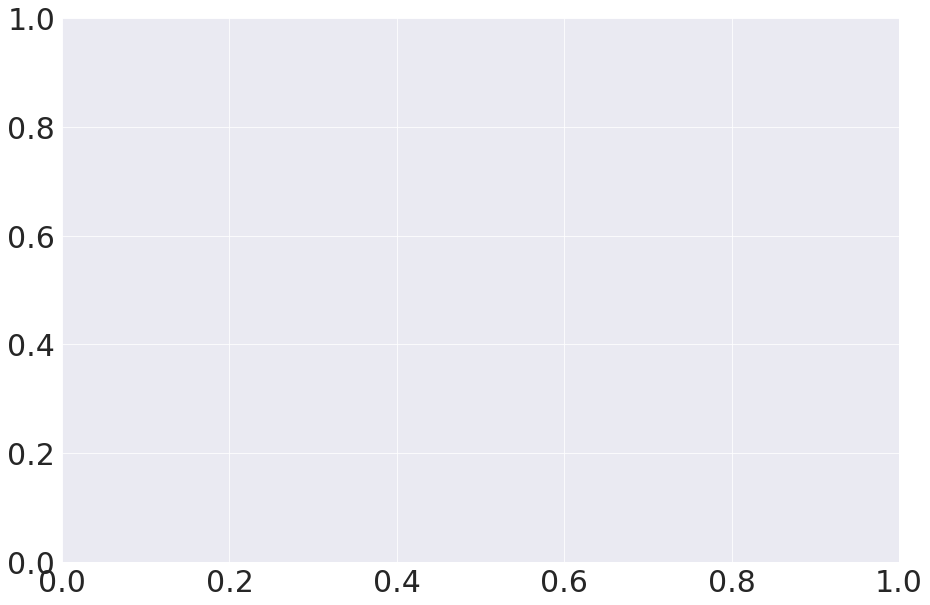

In [29]:
subject_plot(
    plot_type='ese_plot',
    subject_dict=predictions_dict,
    num_bins=10,
    aggregate=True
)